# Marketing Analytics Final Project

## Notebook Contents

1. Business Understanding
    - Objective
    - Description
2. Data Understanding
    - Import libraries
    - Load data
    - Statistical summaries and visualizations
3. Data Preparation
    - Missing values imputation
    - Feature engineering
4. Modeling
    - Select the model
    - Build and fit model
5. Evaluation
    - Model performance
    - Hyperparameter tuning if applicable

### 1.0 Business Understanding

### 1.1 Objectives
- Leverage analytics techniques, such as clustering to identify likely buyer segments & top attributes they're seeking in a home
- Use methods such a regression, to analyze market activity and the  influence both controllable and uncontrollable variables have on sales and the likelihood of selling at a higher sale-to-list price ratio in the shortest amount of time.


### 1.2 Description
The housing market is always a hotly contested area with potential desicions that have lifetime ramifications. Our marketing analytics team has been brought in by Temax Realty group to conduct research to aid their efforts in their offices located in Texas and Missouri

### 2.0 Data Understanding

### 2.1 Import Libraries
First off some preparation. We need to import python libraries containing the necessary functionality we will need.

In [29]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 12 , 8

### Setup Functions
There is no need to understand this code, just some hacks I had previously stashed away to help expedite ML projects.

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3 Load Data
Now that our packages are loaded, let's read in and take a peek at the data

In [3]:
# Price Data
price = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\Sale_Prices_Zip.csv")
price = price[(price['StateName'] == 'Texas') | (price['StateName'] == 'Missouri')]
price.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
2,91982.0,77494,Texas,3,NaN,NaN,NaN,NaN,NaN,NaN,...,317700.0,328400.0,334000.0,337100.0,335900.0,331600.0,337500.0,329400.0,336700.0,NaN
3,93144.0,79936,Texas,4,NaN,NaN,NaN,NaN,NaN,NaN,...,130800.0,128800.0,129600.0,130400.0,128400.0,129200.0,133600.0,135300.0,131200.0,130000.0
4,91940.0,77449,Texas,5,NaN,NaN,NaN,NaN,NaN,NaN,...,173600.0,170900.0,180000.0,183300.0,185600.0,179200.0,180200.0,179300.0,177400.0,180500.0
7,92593.0,78660,Texas,8,NaN,NaN,NaN,NaN,NaN,NaN,...,245800.0,240300.0,239800.0,237600.0,243500.0,243300.0,244700.0,243700.0,246100.0,242400.0
11,92036.0,77573,Texas,12,NaN,NaN,NaN,NaN,NaN,NaN,...,287700.0,284900.0,280900.0,272500.0,267300.0,262100.0,261700.0,261600.0,258800.0,NaN


In [4]:
# Median square Foot Price
med_sqft = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\Zip_MedianListingPricePerSqft_AllHomes.csv", encoding = "ISO-8859-1")
med_sqft = med_sqft[(med_sqft['State'] == 'TX') | (med_sqft['State'] == 'MO')]
med_sqft.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
1,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris,2,98.176079,97.886975,97.799511,98.331210,...,120.655672,119.831223,119.911504,119.911504,120.066780,120.013419,119.689101,119.466146,120.092379,120.440468
3,79936,El Paso,TX,El Paso,El Paso,4,88.688320,88.159032,87.940589,87.929656,...,88.540363,88.755279,88.455330,88.367347,89.118199,90.128755,90.316333,90.700281,91.593625,91.538818
4,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris,5,61.436673,61.401900,62.065541,62.655144,...,92.501056,93.574468,93.574468,95.043228,95.049462,96.115101,96.174004,96.091205,95.104408,94.111969
5,77084,Houston,TX,Houston-The Woodlands-Sugar Land,Harris,6,62.749572,63.458488,63.573701,63.793103,...,88.246634,88.570488,90.556274,91.753568,92.504443,93.656227,92.778335,93.208991,93.765401,93.433349
13,78660,Pflugerville,TX,Austin-Round Rock,Travis,14,83.682008,83.181187,83.649997,84.285714,...,125.098412,126.375268,127.041742,127.512874,126.344086,126.725320,126.483946,126.981265,127.524186,127.630010


In [5]:
# Market Health index and Days on Market
mkt_health_index = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\MarketHealthIndex_Zip.csv")
mkt_health_index = mkt_health_index[(mkt_health_index['State'] == 'TX') | (mkt_health_index['State'] == 'MO')]
mkt_health_index.drop(columns = 'RegionType', inplace = True)
mkt_health_index.head()

,RegionName,City,State,Metro,CBSATitle,SizeRank,MarketHealthIndex,SellForGain,PrevForeclosed,ForeclosureRatio,ZHVI,MoM,YoY,ForecastYoYPctChange,StockOfREOs,NegativeEquity,Delinquency,DaysOnMarket
10326,63005,Chesterfield,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,2.911129,58.82,0.0,0.00,541300.0,-0.147574,3.006660,0.023266,NaN,0.046258,0.020833,75.5
10327,63010,Arnold,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,6.760639,NaN,0.0,0.00,163200.0,0.430769,6.388527,0.060803,NaN,0.063042,0.025000,56.0
10328,63011,Ballwin,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,6.533092,88.89,0.0,0.00,300000.0,0.033344,6.496273,0.017770,NaN,0.041407,0.013378,59.0
10329,63012,Barnhart,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,5.285273,NaN,0.0,2.87,166000.0,0.545124,4.468219,0.070958,NaN,0.061144,0.016129,58.0
10330,63013,Beaufort,MO,"St. Louis, MO, MO","St. Louis, MO",NaN,9.324070,NaN,NaN,NaN,188000.0,0.912507,15.266708,0.048176,NaN,0.063348,0.000000,75.0


In [6]:
# Inventory Measure
inv_measure = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\InventoryMeasure_Zip_Public.csv", encoding = "ISO-8859-1")
inv_measure = inv_measure[(inv_measure['StateFullName'] == 'Texas') | (inv_measure['StateFullName'] == 'Missouri')]
inv_measure.head()

,RegionName,RegionType,City,CountyName,Metro,StateFullName,DataTypeDescription,2010-01,2010-02,2010-03,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
3,77494,Zip,Katy,Harris,Houston-The Woodlands-Sugar Land,Texas,All Homes,822.0,842.0,952.0,...,632.0,578.0,590.0,667.0,652.0,771.0,818.0,840.0,831.0,782
5,79936,Zip,El Paso,El Paso,El Paso,Texas,All Homes,580.0,582.0,580.0,...,241.0,253.0,255.0,246.0,257.0,269.0,258.0,234.0,237.0,244
6,77449,Zip,Katy,Harris,Houston-The Woodlands-Sugar Land,Texas,All Homes,750.0,770.0,834.0,...,254.0,225.0,218.0,232.0,246.0,252.0,244.0,280.0,286.0,266
7,77084,Zip,Houston,Harris,Houston-The Woodlands-Sugar Land,Texas,All Homes,570.0,574.0,644.0,...,202.0,174.0,160.0,162.0,164.0,181.0,192.0,221.0,253.0,236
15,78660,Zip,Pflugerville,Travis,Austin-Round Rock,Texas,All Homes,529.0,576.0,596.0,...,324.0,294.0,294.0,277.0,283.0,335.0,384.0,427.0,439.0,410


In [7]:
# Buyer Seller Index
buyer_seller = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\BuyerSellerIndex_Zip.csv")
buyer_seller = buyer_seller[(buyer_seller['State'] == 'TX') | (buyer_seller['State'] == 'MO')]
buyer_seller.drop(columns = 'RegionType', inplace = True)
buyer_seller.head()

,RegionName,State,CBSA Title,SizeRankCity,SizeRankMetro,PctPriceCut,DaysOnMarket,BuyerSellerIndex,BuyerSellerIndexMetro
0,79109,TX,"Amarillo, TX",2734,181,27.181208,69.0,7.272727,9.10221
1,79106,TX,"Amarillo, TX",5504,181,26.845638,73.5,8.181818,9.10221
2,79107,TX,"Amarillo, TX",6284,181,15.094340,107.0,5.454545,9.10221
3,79118,TX,"Amarillo, TX",7246,181,17.446809,77.0,4.545455,9.10221
4,79015,TX,"Amarillo, TX",7582,181,20.000000,72.0,2.727273,9.10221


In [8]:
# Monthly Turnover
mon_turnover = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\MonthlyTurnover_Zip.csv")
mon_turnover = mon_turnover[(mon_turnover['StateName'] == 'Texas') | (mon_turnover['StateName'] == 'Missouri')]
mon_turnover.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
3,91982.0,77494,Texas,4,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0048,0.0041,0.0043,0.0052,0.0062,0.0069,0.0062,0.0067,0.0068,NaN
4,93144.0,79936,Texas,5,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0022,0.0022,0.0027,0.0030,0.0026,0.0031,0.0030,0.0034,0.0034,0.0036
5,91940.0,77449,Texas,6,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0047,0.0029,0.0035,0.0043,0.0041,0.0054,0.0053,0.0057,0.0058,0.0044
6,91733.0,77084,Texas,7,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0076,0.0059,0.0058,0.0058,0.0052,0.0067,0.0057,0.0055,0.0060,0.0058
12,92593.0,78660,Texas,13,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0047,0.0038,0.0040,0.0056,0.0053,0.0065,0.0065,0.0065,0.0056,0.0049


In [9]:
# % Of homes with increasing values
inc_val = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\Zip_PctOfHomesIncreasingInValues_AllHomes.csv")
inc_val = inc_val[(inc_val['State'] == 'TX') | (inc_val['State'] == 'MO')]
inc_val.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1997-02,1997-03,1997-04,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
27,90654,75052,Grand Prairie,TX,Dallas-Fort Worth-Arlington,Dallas,28,NaN,NaN,NaN,...,94.02,93.88,92.98,93.17,91.93,91.60,91.76,89.87,94.81,95.65
33,86026,63376,Saint Peters,MO,St. Louis,Saint Charles,34,73.45,66.95,53.93,...,34.28,30.20,23.35,17.10,16.78,14.30,49.53,76.30,94.66,95.77
45,90823,75287,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas,46,70.86,69.65,72.78,...,77.10,73.31,70.81,70.49,67.84,68.00,70.92,69.09,59.22,45.31
51,90795,75243,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas,52,NaN,NaN,NaN,...,85.69,83.97,84.88,85.59,82.68,81.96,80.50,69.93,62.55,53.33
67,90665,75067,Lewisville,TX,Dallas-Fort Worth-Arlington,Denton,68,72.12,64.28,67.08,...,94.10,93.65,93.12,94.00,94.04,93.14,93.43,92.20,93.03,85.55


In [10]:
# % of Homes with Price Reductions
price_red = pd.read_csv("C:\\Users\\jmeis\\Desktop\\Zillow Data\\Zip_PctOfListingsWithPriceReductions_AllHomes.csv", encoding = "ISO-8859-1")
price_red = price_red[(price_red['State'] == 'TX') | (price_red['State'] == 'MO')]
price_red.head()

,RegionID,RegionName,City,County,State,Metro,SizeRank,2010-09,2010-10,2010-11,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
3,91982,77494,Katy,Harris,TX,Houston-The Woodlands-Sugar Land,4,13.978495,14.656665,9.192037,...,13.803376,20.422535,17.428571,19.853539,20.673813,23.140496,25.032765,27.150538,25.412778,24.080000
5,93144,79936,El Paso,El Paso,TX,El Paso,6,12.386707,13.193403,13.091483,...,10.833333,17.105263,13.366337,18.181818,12.378641,16.513761,13.447433,16.666667,17.543860,18.717949
6,91940,77449,Katy,Harris,TX,Houston-The Woodlands-Sugar Land,7,13.289037,14.521739,11.257696,...,8.538899,10.079051,7.500000,9.459459,9.950249,11.894273,13.730929,16.951567,21.550388,17.294521
7,91733,77084,Houston,Harris,TX,Houston-The Woodlands-Sugar Land,8,19.240506,16.621622,13.682678,...,10.548523,14.221219,10.786517,11.561866,10.993658,12.915851,13.060429,18.579235,19.156415,16.634799
17,92593,78660,Pflugerville,Travis,TX,Austin-Round Rock,18,17.222222,18.244014,10.839161,...,15.140187,22.524272,17.064846,18.421053,18.619583,24.611033,25.285896,27.463054,21.113990,24.892704


### Data Sources and Variable Descriptions
- Zillow
    - [X] Price
    - [X] Median Price per sq ft
    - [X] Days on Market
    - [X] % of Listings with Price Reductions
    - [X] % of Homes Increasing in Value
    - [X] Inventory Measure
    - [X] Market Health Index
    - [X] Buyer/Seller Index
    - [X] Monthly Turnover
- US Census Bureau
    - Crime Rate
    - Average Commute Time
    - School District Rankings
    - EASI Weather Index
    - EASI Quality of Life Index
    - Property Tax Rate %

### 2.4 Statistical Summaries and visualizations

Text(0.5,20.8,'USD')

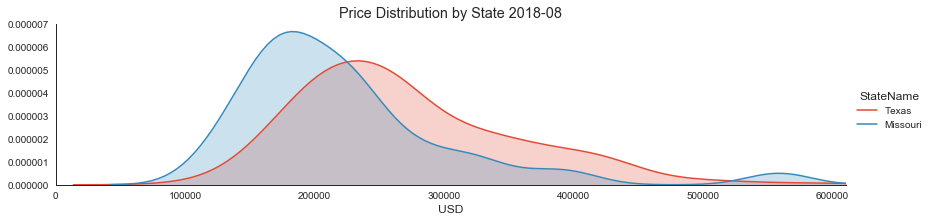

In [11]:
# Distribution of price, hue between Texas and Missouri
plot_distribution(df = price, var = '2018-08', target = 'StateName')
plt.title("Price Distribution by State 2018-08")
plt.xlabel("USD")

In [12]:
# Highest regions to live in Texas
#tx_price_sort = price[price['StateName'] == 'Texas']
#tx_price_sort.rename(columns = {'2018-08': 'August2018'}, inplace = True)
#tx_price_sort.sort_values(by = ['2018-08'], axis = 1, ascending = False, inplace = True)
#tx_price_sort.head()

In [13]:
# Highest regions to live in MIssouri
#mo_price_sort = price[price['StateName'] == 'Missouri']
#mo_price_sort.sort_values(by = '2018-08', axis = 1, ascending = False, inplace = True)
#mo_price_sort.head()

Text(0.5,20.8,'USD')

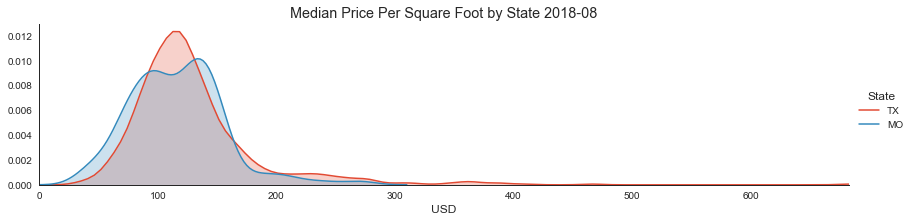

In [14]:
# Distribution of median square foot price, hue between Texas and Missouri
plot_distribution(df = med_sqft , var = '2018-08', target = 'State')
plt.title("Median Price Per Square Foot by State 2018-08")
plt.xlabel("USD")

Text(0.5,20.8469,'Days')

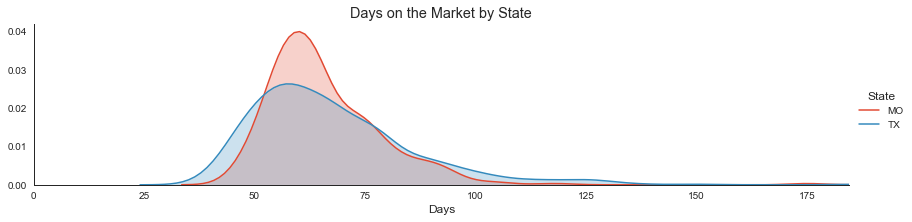

In [15]:
# Distribution of days on Market, hue between Texas and Missouri
plot_distribution(df = mkt_health_index , var = 'DaysOnMarket', target = 'State')
plt.title("Days on the Market by State")
plt.xlabel("Days")

Text(0.5,20.8,'Price Reductions')

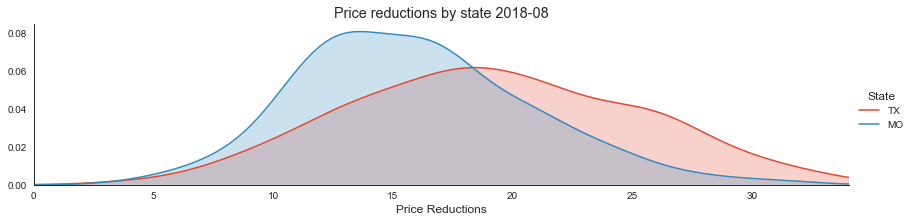

In [16]:
# % of listings with price reductions, hue between Texas and Missouri
plot_distribution(df = price_red , var = '2018-08', target = 'State')
plt.title("Price reductions by state 2018-08")
plt.xlabel("Price Reductions")

Text(0.5,20.8,'Price Increases')

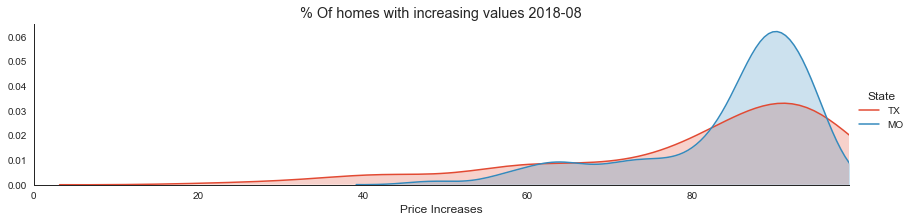

In [17]:
# % of homes with increasing values, hue between Texas and Missouri
plot_distribution(df = inc_val , var = '2018-08', target = 'State')
plt.title("% Of homes with increasing values 2018-08")
plt.xlabel("Price Increases")

Text(0.5,20.8,'Inventory')

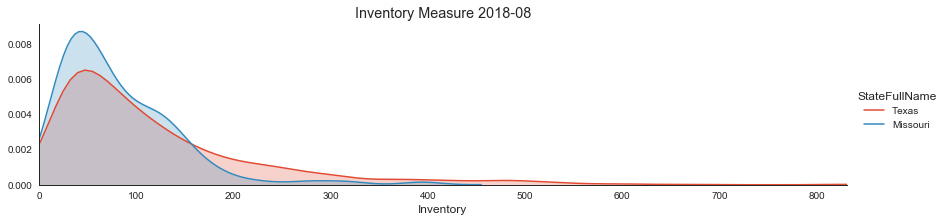

In [18]:
# Inventory measure, hue between Texas and Missouri
plot_distribution(df = inv_measure , var = '2018-08', target = 'StateFullName')
plt.title("Inventory Measure 2018-08")
plt.xlabel("Inventory")

Text(0.5,20.8,'Market Health index')

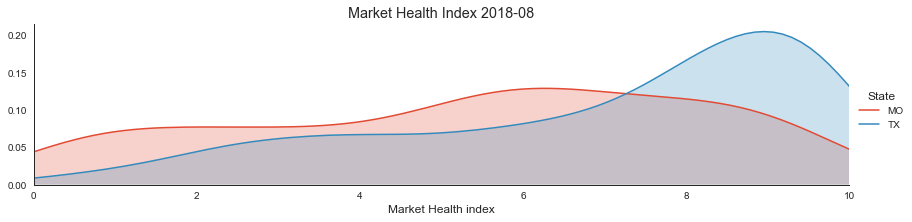

In [19]:
# Market Health index, hue between Texas and Missouri
plot_distribution(df = mkt_health_index , var = 'MarketHealthIndex', target = 'State')
plt.title("Market Health Index 2018-08")
plt.xlabel("Market Health index")

Text(0.5,20.8,'Buyer/Seller index')

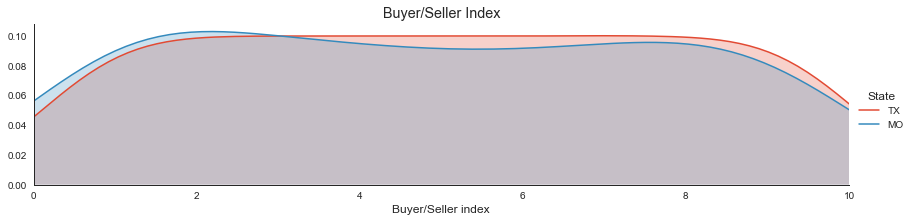

In [20]:
# Buyer/Seller index, hue between Texas and Missouri
plot_distribution(df = buyer_seller , var = 'BuyerSellerIndex', target = 'State')
plt.title("Buyer/Seller Index")
plt.xlabel("Buyer/Seller index")

Text(0.5,1,' % Price Cut Per Days On Market')

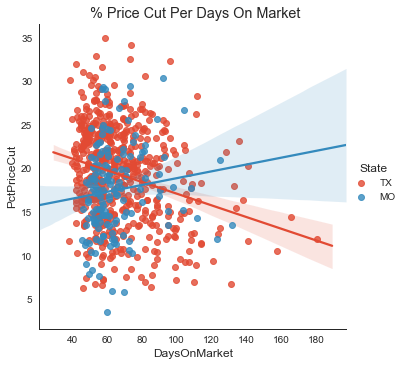

In [30]:
sns.lmplot(x='DaysOnMarket', y='PctPriceCut', data=buyer_seller, hue = 'State')
plt.title(" % Price Cut Per Days On Market")

Text(0.5,20.8,'Monthly Turnover')

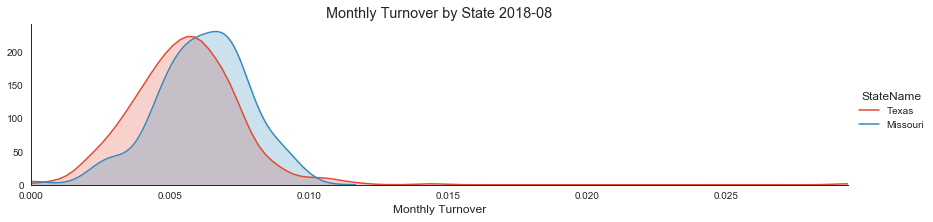

In [22]:
# Monthly Turnover, hue between Texas and Missouri
plot_distribution(df = mon_turnover, var = '2018-08', target = 'StateName')
plt.title("Monthly Turnover by State 2018-08")
plt.xlabel("Monthly Turnover")